In [1]:
import numpy as np
import cv2

# Helper Methods

In [2]:
def getUniqueColors(num):
  cm = plt.get_cmap('gist_rainbow')
  colors_norm = [cm(1.*i/num) for i in range(num)]
  return [(int(255 * r), int(255 * g), int(255 * b)) for r, g, b, _ in colors_norm]

# Train and Load Model

In [12]:
import pickle
import yaml
from sklearn import svm

model_path = "../models/LinearSVC_spatial_1_8x8_8000.sav"
config_path = "../models/LinearSVC_spatial_1_8x8_8000.yaml"

# load model
clf = pickle.load(open(model_path, 'rb'))
print(clf)

# load model configs
with open(config_path, "r") as stream:
  try:
    configs = yaml.safe_load(stream)
    dataset_configs = configs["dataset"]
    preprocessing_configs = configs["preprocessing"]
    svm_configs = configs["svm"]
    
    # Dataset parameters
    positive_negative_ratio = dataset_configs["positive_negative_ratio"]
    min_intersection_ratio = dataset_configs["min_intersection_ratio"]
    number_of_positive_samples = dataset_configs["number_of_positive_samples"]

    # Preprocessing parameters
    input_shape = (preprocessing_configs["input_shape"]["y"], preprocessing_configs["input_shape"]["x"])
    orientations = preprocessing_configs["orientations"] # number of orientation bins
    pixels_per_cell = (preprocessing_configs["pixels_per_cell"]["y"], preprocessing_configs["pixels_per_cell"]["x"]) # number of pixels per cell
    cells_per_block = (preprocessing_configs["cells_per_block"]["y"], preprocessing_configs["cells_per_block"]["x"]) # number of cells per block

    # SVM parameters
    C = svm_configs["C"]
    bagging = svm_configs["bagging"]
    n_estimators = svm_configs["n_estimators"]
    
    print(dataset_configs)
    print(preprocessing_configs)
    print(svm_configs)
  except yaml.YAMLError as exc:
    print(exc)

LinearSVC(C=1000)
{'min_intersection_ratio': 0.8, 'number_of_positive_samples': 8000, 'positive_negative_ratio': 1}
{'cells_per_block': {'x': 2, 'y': 2}, 'input_shape': {'x': 64, 'y': 64}, 'orientations': 9, 'pixels_per_cell': {'x': 8, 'y': 8}}
{'C': 1000, 'bagging': False, 'n_estimators': 50}


# Load Test Images

## Load Images and Bboxes

In [13]:
def parse(filepath):
  '''
      Parse gt.txt with format
        <frame>, <id>, <type>, <truncated>, <occluded>, <alpha>, <bb_left>, <bb_top>, <bb_right>, <bb_bottom>, <3D_H>, <3D_W>, <3D_L>, <x>, <y>, <z>, <ry>
      Return dict as:
        <type> = "Car", "Van", "Truck", "Pedastrian", "Person_sitting", "Cyclist", "Tram", "Misc", "DontCare"
        key: frame
        value: list - <id>, <bb_left>, <bb_top>, <bb_right>, <bb_bottom>, <is_vehicle>
      Feel free to edit your structure as needed!
  '''

  used_type = ["Car", "Van", "Truck", "Tram"]

  lines = open(filepath, "r").readlines()                                 
  bbox = {}

       #  <frame>, <id>, <truncated>, <occluded>, <alpha>, <bb_left>, <bb_top>, <bb_right>, <bb_bottom>, <3D_H>, <3D_W>, <3D_L>, <x>,   <y>,   <z>,   <ry>
  mask = [False,   False,  False,       False,      False,   True,      True,     True,       True,        False,  False,  False,  False, False, False, False]
  
  for line in lines:
    l = line.strip().split(' ') #convert line to list
    typ = l.pop(2)  # get type of bbox 
    line = np.asarray(l).astype(np.float32) # convert into array 
    frame, line = int(line[0]), line[mask] # get frame number and mask the line   
    if frame not in bbox.keys():
      bbox[frame] = []   
    if typ in used_type:
      bbox[frame].append(line)
  
  for frame in bbox.keys():
    bbox[frame] = np.asarray(bbox[frame], np.int32)
    
  return bbox

In [75]:
dataset_path = "../datasets/dataset"

bboxes = []
images = []
for seq_id in range(3):
    seq_bboxes_dict = parse(f'{dataset_path}/{seq_id:04d}.txt')

    for frame_id in range(len(seq_bboxes_dict.keys())):
        image = cv2.imread(f'{dataset_path}/{seq_id:04d}/{frame_id:06d}.png')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        images.append(image)
        bboxes.append(seq_bboxes_dict[frame_id])

    
images = np.array(images, dtype=np.uint8)
# bboxes = np.array(bboxes, dtype=np.int32)

# print(images.shape)
# print(bboxes)

## Select Random Image

(1242, 375)


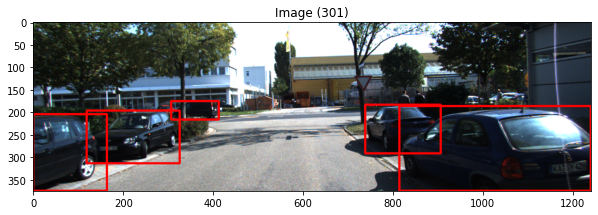

In [114]:
import cv2
from random import randint
import matplotlib.pyplot as plt

random_i = randint(0,len(images))

img_bboxes = bboxes[random_i]

img = images[random_i]
img_h, img_w, _ = img.shape
print((img_w, img_h))

img_ground_truth = img.copy()
for xi, yi, xf, yf in img_bboxes: 
  img_ground_truth = cv2.rectangle(img_ground_truth, (xi, yi), (xf, yf), (255, 0, 0), 4)

# plot image
plt.figure(figsize=(10,10))
plt.title(f"Image ({random_i})")
plt.imshow(img_ground_truth)

plt.show()

## Sliding Window

In [115]:
def makeWindows(image_size, window_size, overlap=(0.5,0.5), x_range=(0, 1), y_range=(0, 1)):
    x_overlap, y_overlap = overlap
    window_w, window_h = window_size
    w, h = image_size
    
    windows = []
    y_step = int((1 - y_overlap) * window_h)
    for y in range(int(y_range[0] * h), int(y_range[1] * h), y_step):
        if y + window_h > int(y_range[1] * h) or window_w > w:
            break
        
        x_step = int((1 - x_overlap) * window_w)
        for x in range(int(x_range[0] * w), int(x_range[1] * w), x_step):
            windows.append((x, y, x + window_w, y + window_h))
            
    return np.array(windows)
    
def pyramidWindows(image_size, init_size=(64,64), overlap=(0.5,0.5), x_range=(0, 1), y_range=(0, 1), scale=1.5, steps=4):
    windows = None
    for i in range(0, steps):
        cur_scale = scale ** i
        window_size = (int(init_size[0] * cur_scale), int(init_size[1] * cur_scale))
        
        pyramid_windows = makeWindows(image_size, window_size, overlap=overlap, x_range=x_range, y_range=y_range)
        
        if windows is None:
            windows = pyramid_windows
        else:
            windows = np.vstack((windows, pyramid_windows))
        
    return windows


def slidingWindow(image_size, init_size=(64,64), x_overlap=0.5, y_step=0.05,
        x_range=(0, 1), y_range=(0, 1), scale=1.5, dims=False):
    windows = []
    y_count = 0
    h, w = image_size[1], image_size[0]
    for y in range(int(y_range[0] * h), int(y_range[1] * h), int(y_step * h)):
        y_count += 1
        win_width = int(init_size[0] + (scale * (y - (y_range[0] * h))))
        win_height = int(init_size[1] + (scale * (y - (y_range[0] * h))))
        if y + win_height > int(y_range[1] * h) or win_width > w:
            break
        x_step = int((1 - x_overlap) * win_width)
        for x in range(int(x_range[0] * w), int(x_range[1] * w), x_step):
            windows.append((x, y, x + win_width, y + win_height))

    if (dims):
        return windows, y_count
    return windows

1218
867


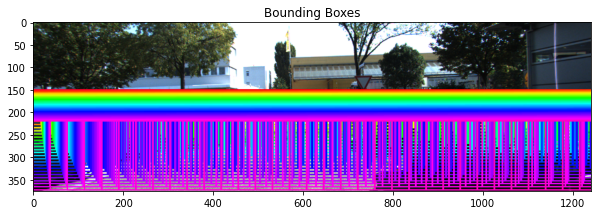

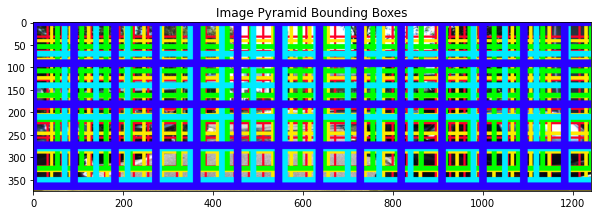

In [140]:
# show windows 
sliding_windows = slidingWindow((img_w, img_h),
                        init_size=(64,64), 
                        x_overlap=0.75, 
                        y_step=0.01, 
                        x_range=(0, 1), 
                        y_range=(0.4, 1), 
                        scale=1.3)

pyramid_windows = pyramidWindows((img_w, img_h), 
                                 init_size=(64,64), 
                                 overlap=(0.5, 0.5), 
                                 x_range=(0, 1), 
                                 y_range=(0, 1),
                                 scale=1.3,
                                 steps=5)

img_windows = img.copy()
colors = getUniqueColors(len(sliding_windows))
for i, (xi, yi, xf, yf) in enumerate(sliding_windows): 
  img_windows = cv2.rectangle(img_windows, (xi, yi), (xf, yf), colors[i], 2)

img_pyramid_windows = img.copy()
colors = getUniqueColors(5)
prev_size = None
color_i = -1
for i, (xi, yi, xf, yf) in enumerate(pyramid_windows): 
  if prev_size is None or prev_size != xf - xi: 
    prev_size = xf - xi
    color_i += 1
    
  img_pyramid_windows = cv2.rectangle(img_pyramid_windows, (xi, yi), (xf, yf), colors[color_i], 3 + 3 * color_i)
  
print(len(sliding_windows))
print(len(pyramid_windows))

# boxes
plt.figure(figsize = (10, 10)) 
plt.title("Bounding Boxes")
plt.imshow(img_windows)
plt.show()

plt.figure(figsize = (10, 10)) 
plt.title("Image Pyramid Bounding Boxes")
plt.imshow(img_pyramid_windows)
plt.show()

# Predict

In [141]:
from tools.v2.preprocessing_v2 import preprocess_images_v2

compute_spatial_features = True
hist_features = False
windows = sliding_windows 
windows = pyramid_windows

window_images = [ cv2.resize(img[yi:yf, xi:xf, :], (input_shape[1], input_shape[0])) for (xi, yi, xf, yf) in windows]
window_images = np.array(window_images, dtype=np.float64)

print(window_images.shape)
 
feature_vectors = preprocess_images_v2(window_images, orientations, pixels_per_cell, cells_per_block, compute_spatial_features=compute_spatial_features, hist_features=hist_features) 

print(feature_vectors.shape)

predictions = clf.predict(feature_vectors)

boxes = [windows[ind] for ind in np.argwhere(predictions == 1)[:,0]]

(867, 64, 64, 3)


/opt/homebrew/lib/python3.9/site-packages/skimage/_shared/utils.py:338: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0.Please use `channel_axis` instead.
  return func(*args, **kwargs)


(867, 2964)


## Show bounding boxes

percentage of positives: 0.03690888119953864


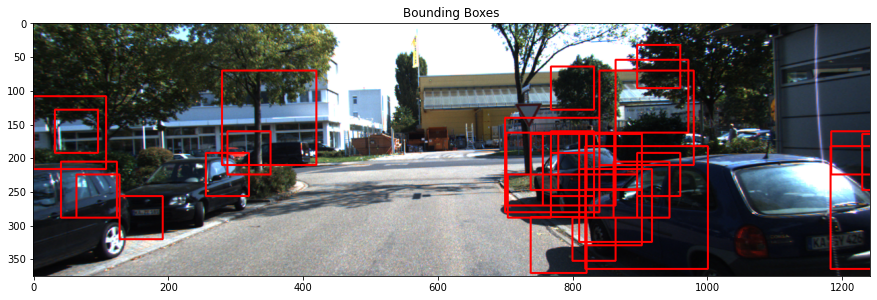

In [142]:
img_boxes = img.copy()

colors = getUniqueColors(len(boxes))

for i, (xi, yi, xf, yf) in enumerate(boxes): 
  # img_boxes = cv2.rectangle(img_boxes, (xi, yi), (xf, yf), colors[i], 2)
  img_boxes = cv2.rectangle(img_boxes, (xi, yi), (xf, yf), (255, 0, 0), 2)
  
ratio_of_positives = len(boxes) / len(windows)
print(f"percentage of positives: {ratio_of_positives}")
  
# boxes
plt.figure(figsize = (15, 15)) 
plt.title("Bounding Boxes")
plt.imshow(img_boxes)
plt.show()

### Non-Maximum Suppression

In [ ]:
from scipy.ndimage.measurements import label

# https://towardsdatascience.com/non-maxima-suppression-139f7e00f0b5#:~:text=The%20Non%2Dmaximum%20suppression%20(NMS,contains%20a%20different%20bounding%20box.&text=The%20overlap%20treshold%20determines%20the,boxes%20are%20allowed%20to%20have.
def nonMaxSuppression(boxes, overlapThresh=0.4, show=False):
  # if there are no boxes, return an empty list
	if len(boxes) == 0:
		return []

	# if the bounding boxes integers, convert them to floats --
	# this is important since we'll be doing a bunch of divisions
	if boxes.dtype.kind == "i":
		boxes = boxes.astype("float")
	# initialize the list of picked indexes	
	pick = []
	# grab the coordinates of the bounding boxes
	x1 = boxes[:,0]
	y1 = boxes[:,1]
	x2 = boxes[:,2]
	y2 = boxes[:,3]
	# compute the area of the bounding boxes and sort the bounding
	# boxes by the bottom-right y-coordinate of the bounding box
	area = (x2 - x1 + 1) * (y2 - y1 + 1)
	idxs = np.argsort(y2)
	# keep looping while some indexes still remain in the indexes
	# list
	while len(idxs) > 0:
		# grab the last index in the indexes list and add the
		# index value to the list of picked indexes
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)
		# find the largest (x, y) coordinates for the start of
		# the bounding box and the smallest (x, y) coordinates
		# for the end of the bounding box
		xx1 = np.maximum(x1[i], x1[idxs[:last]])
		yy1 = np.maximum(y1[i], y1[idxs[:last]])
		xx2 = np.minimum(x2[i], x2[idxs[:last]])
		yy2 = np.minimum(y2[i], y2[idxs[:last]])
		# compute the width and height of the bounding box
		w = np.maximum(0, xx2 - xx1 + 1)
		h = np.maximum(0, yy2 - yy1 + 1)
		# compute the ratio of overlap
		overlap = (w * h) / area[idxs[:last]]
		# delete all indexes from the index list that have
		idxs = np.delete(idxs, np.concatenate(([last],
			np.where(overlap > overlapThresh)[0])))
	# return only the bounding boxes that were picked using the
	# integer data type
	return boxes[pick].astype("int")

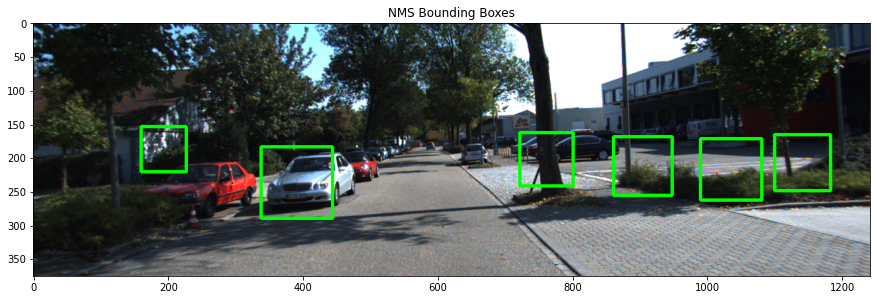

In [ ]:
overlapThresh = 0.2

nms_boxes = nonMaxSuppression(np.array(boxes), overlapThresh=overlapThresh)

img_boxes = img.copy()
for xi, yi, xf, yf in nms_boxes: 
  img_boxes = cv2.rectangle(img_boxes, (xi, yi), (xf, yf), (0, 255, 0), 4)
  
# boxes
plt.figure(figsize = (15, 15)) 
plt.title("NMS Bounding Boxes")
plt.imshow(img_boxes)
plt.show()

### Group Rectangles

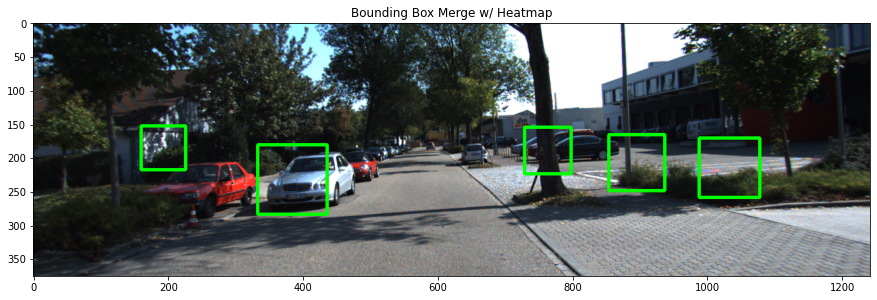

In [ ]:
merged_boxes,  _ = cv2.groupRectangles(boxes, 1)

img_labels = img.copy()
for xi, yi, xf, yf in merged_boxes: 
    cv2.rectangle(img_labels, (xi, yi), (xf, yf), (0, 255, 0), 4)


# plot final
plt.figure(figsize = (15, 15)) 
plt.title("Bounding Box Merge w/ Heatmap")
plt.imshow(img_labels)
plt.show()      


### Heat Map

In [ ]:
# https://nrsyed.com/2018/05/24/hog-based-svm-for-detecting-vehicles-in-a-video-part-6/
def heatmapMerge(boxes, img_size, threshold=2, min_bbox=(40,40), show=False):
    current_heatmap = np.zeros(img_size, dtype=np.float32)
    for (xi, yi, xf, yf) in boxes:
        current_heatmap[yi:yf, xi:xf] += 1

    # set treshold values to 0
    threshold_heatmap = current_heatmap.copy()
    threshold_heatmap[current_heatmap <= threshold] = 0

    # label images
    heatmap_labels = np.zeros((img_h, img_w))
    num_objects = label(threshold_heatmap, output=heatmap_labels)
    
    heatmap_boxes = []
    for obj in range(1, num_objects + 1):
        (Y_coords, X_coords) = np.nonzero(heatmap_labels == obj)
        xi, yi = min(X_coords), min(Y_coords)
        xf, yf = max(X_coords), max(Y_coords)

        # Only draw box if object is larger than min bbox size.
        if (xf - xi > min_bbox[0] and yf - yi > min_bbox[1]):
            heatmap_boxes.append((xi, yi, xf, yf))
            
    # show heatmap
    if show:
        plt.figure(figsize=(20,10))
        plt.subplot(121)
        plt.title("Heat Map")
        plt.imshow(current_heatmap, cmap="inferno")
        plt.subplot(122)
        plt.title("Thresholded Heat Map")
        plt.imshow(threshold_heatmap, cmap="inferno")
        plt.show()
        
    return heatmap_boxes

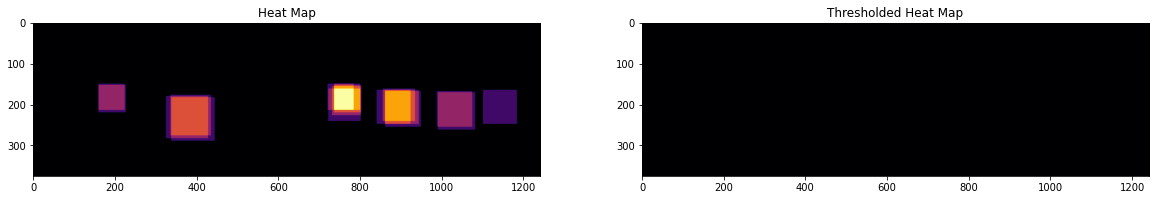

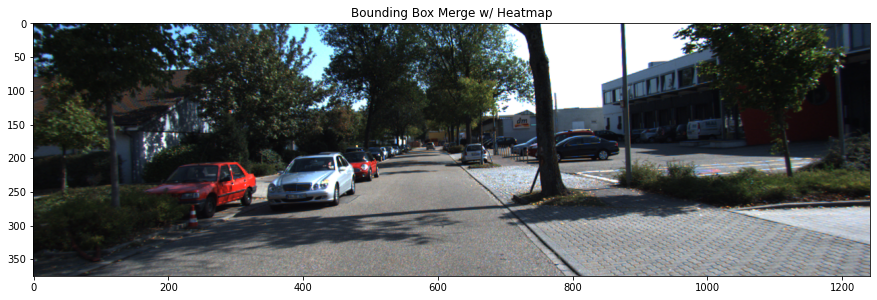

In [ ]:
from scipy.ndimage.measurements import label

heatmapThresh = 5
min_bbox = (40,40)

heatmap_boxes = heatmapMerge(boxes, (img_h, img_w), threshold=heatmapThresh, min_bbox=min_bbox, show=True)

img_labels = img.copy()
for xi, yi, xf, yf in heatmap_boxes: 
    cv2.rectangle(img_labels, (xi, yi), (xf, yf), (0, 255, 0), 4)


# plot final
plt.figure(figsize = (15, 15)) 
plt.title("Bounding Box Merge w/ Heatmap")
plt.imshow(img_labels)
plt.show()      


# Full Pipeline

In [ ]:
from tools.v2.preprocessing_v2 import preprocess_images_v2

def detectVehicles(img, clf, input_shape, orientations, pixels_per_cell, cells_per_block, compute_spatial_features=True, hist_features=False,
                   merging_type="nms", nmsOverlapThresh=0.4, 
                   heatmapThresh=2, heatmapMinBbox=(40,40),
                   show=False):
  h, w, _ = img.shape
  
  # get sliding windows windows
  sliding_windows = slidingWindow((img_w, img_h),
                        init_size=(64,64), 
                        x_overlap=0.75, 
                        y_step=0.01, 
                        x_range=(0, 1), 
                        y_range=(0.4, 1), 
                        scale=1.3)
  
  # get sub-images from original image
  window_images = [ cv2.resize(img[yi:yf, xi:xf, :], (input_shape[1], input_shape[0])) for (xi, yi, xf, yf) in sliding_windows]
  window_images = np.array(window_images, dtype=np.float64)
  
  # pre-proccess images
  feature_vectors = preprocess_images_v2(window_images, orientations, pixels_per_cell, cells_per_block, compute_spatial_features=compute_spatial_features, hist_features=hist_features) 

  # predict using classifier
  predictions = clf.predict(feature_vectors)

  # bounding boxes of windows classified as vehicles  
  boxes = [sliding_windows[ind] for ind in np.argwhere(predictions == 1)[:,0]]
  
  # merge bounding boxes
  if (merging_type == "nms"):
    nms_boxes = nonMaxSuppression(np.array(boxes), overlapThresh=nmsOverlapThresh)   
    return nms_boxes
  elif (merging_type == "group"):
    grouped_boxes, _ = cv2.groupRectangles(boxes, 1) 
    return grouped_boxes
  elif (merging_type == "heatmap"):
    heatmap_boxes = heatmapMerge(boxes, (h,w), threshold=heatmapThresh, min_bbox=heatmapMinBbox, show=show)   
    return heatmap_boxes
  

def multiImageDetection(images, clf, input_shape, orientations, pixels_per_cell, cells_per_block, 
                   merging_type="nms"):
  
  bboxes = []
  for image in images:
    img_bboxes = detectVehicles(image, clf, input_shape, orientations, pixels_per_cell, cells_per_block, 
                   merging_type=merging_type)
    bboxes.append(img_bboxes)
    
  return img_bboxes  

# Statistics

In [ ]:
def iou(a, b):
  # determine the (x, y)-coordinates of the intersection rectangle
  xi = max(a[0], b[0])
  yi = max(a[1], b[1])
  xf = min(a[2], b[2])
  yf = min(a[3], b[3])
  # compute the area of intersection rectangle
  interArea = max(0, xf - xi + 1) * max(0, yf - yi + 1)
  # compute the area of both the prediction and ground-truth
  # rectangles
  aArea = (a[2] - a[0] + 1) * (a[3] - a[1] + 1)
  bArea = (b[2] - b[0] + 1) * (b[3] - b[1] + 1)
  # compute the intersection over union by taking the intersection
  # area and dividing it by the sum of prediction + ground-truth
  # areas - the interesection area
  iou = interArea / float(aArea + bArea - interArea)
  # return the intersection over union value
  return iou

In [ ]:
from statistics import mean

test_images = images[:20]
test_bboxes = bboxes[:20]

print(test_images.shape)

ious = []
for i, image in enumerate(test_images):
  gt_boxes = test_bboxes[i]
  pred_bboxes = detectVehicles(image, clf, input_shape, orientations, pixels_per_cell, cells_per_block, 
                   merging_type="nms")
  
  total_iou = 0
  for pred_box in pred_bboxes:
    max_iou = 0
    for gt_box in gt_boxes:
      cur_iou = iou(pred_box, gt_box)
      if (max_iou < cur_iou):
        max_iou = cur_iou

    total_iou += max_iou
  
  if len(pred_bboxes) == 0 and len(gt_boxes) == 0:
    avg_iou = 1
  elif len(pred_bboxes) == 0: 
    avg_iou = 0
  else:
    avg_iou = total_iou / len(pred_bboxes)
  
  ious.append(avg_iou)

print(ious)
print(mean(ious))

(20, 375, 1242, 3)


/opt/homebrew/lib/python3.9/site-packages/skimage/_shared/utils.py:338: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0.Please use `channel_axis` instead.
  return func(*args, **kwargs)
/opt/homebrew/lib/python3.9/site-packages/skimage/_shared/utils.py:338: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0.Please use `channel_axis` instead.
  return func(*args, **kwargs)
/opt/homebrew/lib/python3.9/site-packages/skimage/_shared/utils.py:338: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0.Please use `channel_axis` instead.
  return func(*args, **kwargs)
/opt/homebrew/lib/python3.9/site-packages/skimage/_shared/utils.py:338: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0.Please use `channel_axis` instead.
  return func(*args, **kwargs)
/opt/homebrew/lib/python3.9/

[0.13400797301441275, 0.11455169421324603, 0.1023059434881455, 0.09838846480067855, 0.09207161125319693, 0.16672443674176776, 0.3011948908117017, 0, 0, 0.29677385846527554, 0.2855807712278829, 0.4271183144927765, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
0.10093589792545421
